Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing Skin Cancer Data

# #To do: Take necessary actions to read the data

# Importing all the important libraries

In [1]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.utils import plot_model

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r'C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train')
data_dir_test = pathlib.Path(r'C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# # Load using keras.preprocessing

Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

# # Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.2
seed_train_validation = 123
shuffle_value = True

Use 80% of the images for training, and 20% for validation.

In [6]:
#https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# help(tf.keras.preprocessing.image_dataset_from_directory)

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size = (img_height, img_width),
                                                               validation_split = validation_split,
                                                               subset = "training",
                                                               seed = seed_train_validation,
                                                               color_mode = 'rgb',
                                                               shuffle = shuffle_value)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                             batch_size=batch_size,
                                                             image_size = (img_height, img_width),
                                                             validation_split = validation_split,
                                                             subset = "validation",
                                                             seed = seed_train_validation,
                                                             color_mode = 'rgb',
                                                             shuffle = shuffle_value)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'output', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# # Visualize the dataset

Todo, create a code to visualize one instance of all the nine classes present in the dataset

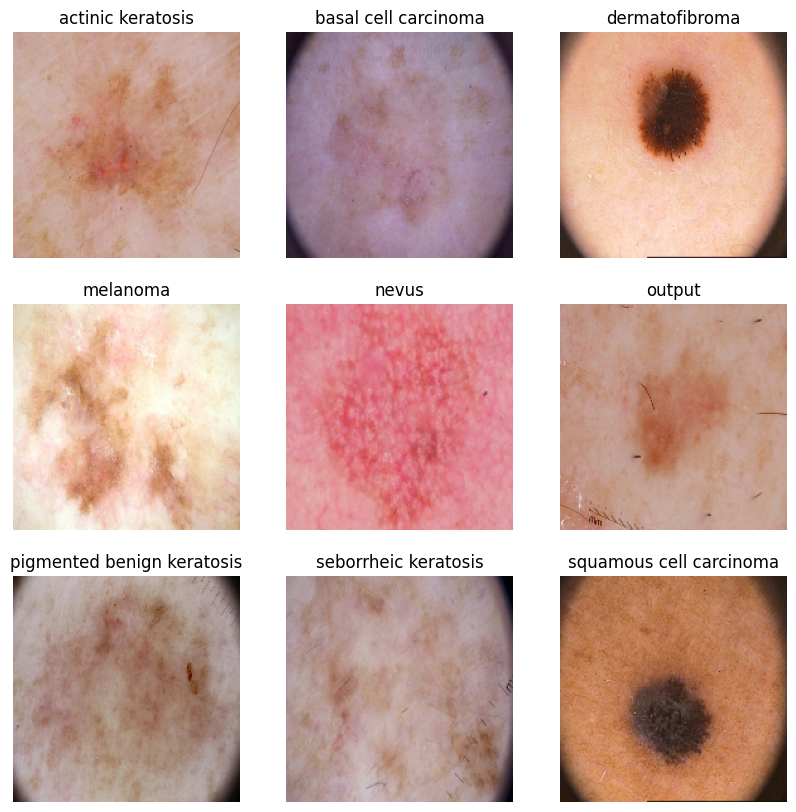

In [20]:
#Visualize one instance of all the class present in the dataset.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

- Visualize the data

In [21]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,.ipynb_checkpoints,1
1,actinic keratosis,114
2,basal cell carcinoma,376
3,dermatofibroma,95
4,melanoma,438
5,nevus,357
6,output,0
7,pigmented benign keratosis,462
8,seborrheic keratosis,77
9,squamous cell carcinoma,181


<Axes: xlabel='No. of Image', ylabel='Class'>

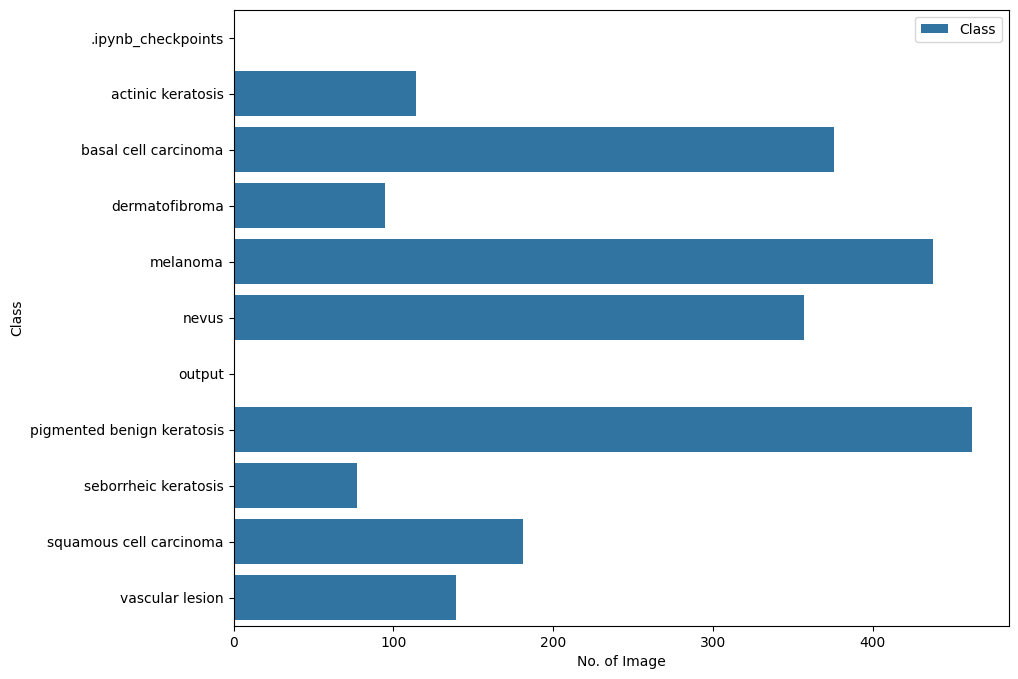

In [23]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
### Your code goes here
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model= Sequential([
       tf.keras.layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
       #First convolving layer
       layers.Conv2D(16,kernel_size=(3,3), padding='same',activation='relu'),
       layers.MaxPooling2D(),
       #Second convolving layer
       layers.Conv2D(32,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Third convolving layer
       layers.Conv2D(64,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Dropout layer with 50% Fraction of the input units to drop.
       layers.Dropout(0.5),
       #adding the Flatten layer
       layers.Flatten(),
       # adding Dense layer
       layers.Dense(128, activation='relu'),
       #Dropout layer with 25% Fraction of the input units to drop.
       layers.Dropout(0.25),
       layers.Dense(len(class_names))

])

model.summary()

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,930 (15.22 MB)

 Trainable params: 3,989,930 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

# Compile the model

Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

- Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.6491 - loss: 1.5578 - val_accuracy: 0.6726 - val_loss: 1.3430
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.6615 - loss: 1.3134 - val_accuracy: 0.6711 - val_loss: 1.2849
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.6744 - loss: 1.2492 - val_accuracy: 0.6726 - val_loss: 1.2176
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 414ms/step - accuracy: 0.6581 - loss: 1.2362 - val_accuracy: 0.6726 - val_loss: 1.2236
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 458ms/step - accuracy: 0.6553 - loss: 1.2228 - val_accuracy: 0.6719 - val_loss: 1.2551
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 423ms/step - accuracy: 0.6604 - loss: 1.1901 - val_accuracy: 0.6741 - val_loss: 1.2294
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 399ms/step - accuracy: 0.6664 - loss: 1.1879 - val_accuracy: 0.6748 - val_loss: 1.1853
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 71s 421ms/step - accuracy: 0.6551 - loss: 1

# Visualising training results

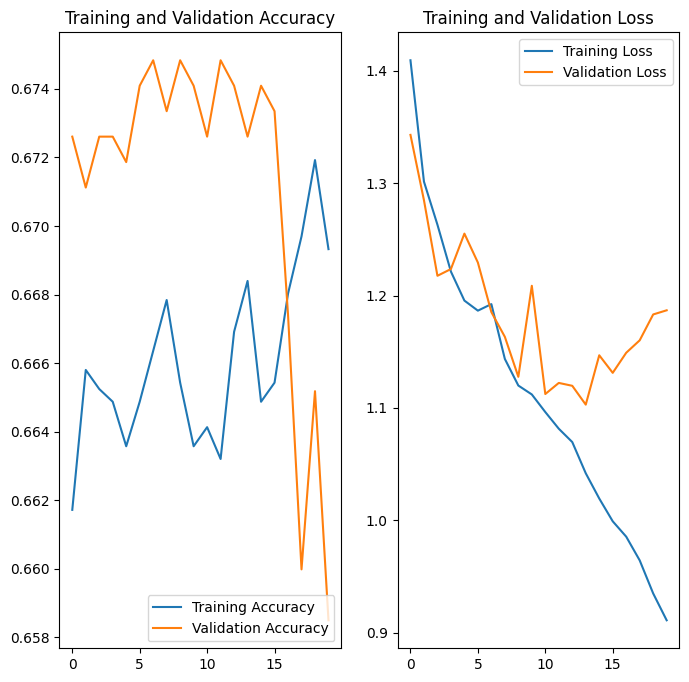

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

# Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Actual Class basal cell carcinoma
Predictive Class output


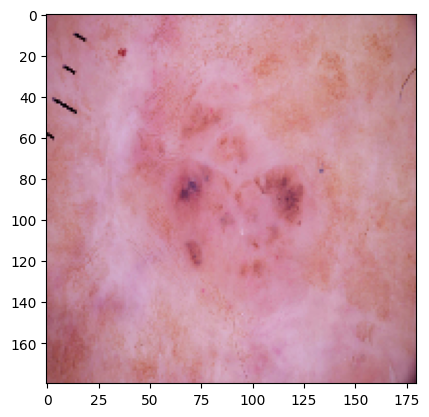

In [18]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

- Write your findings here

In [24]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    tf.keras.layers.RandomCrop(img_height,img_width),
  ]
)

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


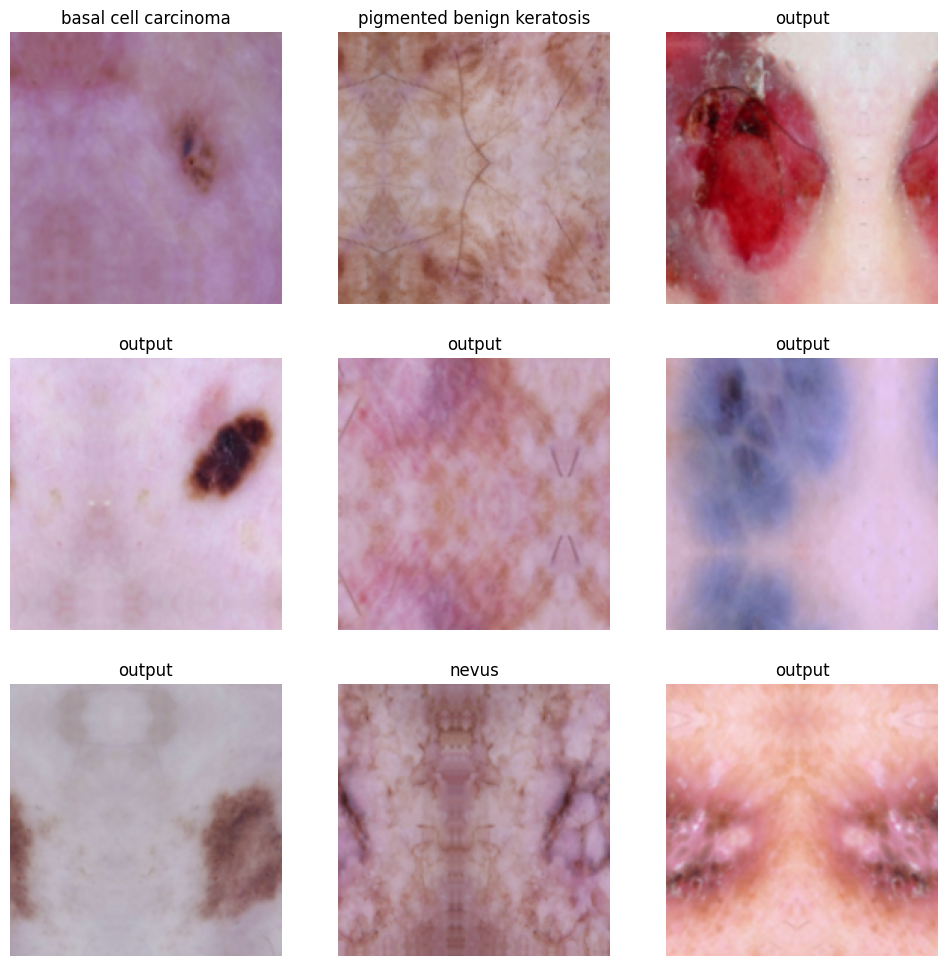

In [25]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Todo

## Create the model, compile and train the model

In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential([data_augmentation, tf.keras.layers.Rescaling(1/255,input_shape=(180,180,3))])

#model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
# model.add(tf.keras.layers.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
#Dropout layer with 50% Fraction of the input units to drop.
# model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

- Compiling the model

In [29]:
## Your code goes here
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training the model

In [30]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.6515 - loss: 1.6805 - val_accuracy: 0.6726 - val_loss: 1.3368
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.6617 - loss: 1.3628 - val_accuracy: 0.6726 - val_loss: 1.3361
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6646 - loss: 1.3326 - val_accuracy: 0.6726 - val_loss: 1.3216
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.6774 - loss: 1.2853 - val_accuracy: 0.6726 - val_loss: 1.3470
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.6629 - loss: 1.3444 - val_accuracy: 0.6726 - val_loss: 1.3390
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.6709 - loss: 1.3080 - val_accuracy: 0.6726 - val_loss: 1.3496
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6726 - loss: 1.3119 - val_accuracy: 0.6726 - val_loss: 1.3360
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6701 - loss: 1.3029 - val_accuracy: 0.672

## Visualizing the results

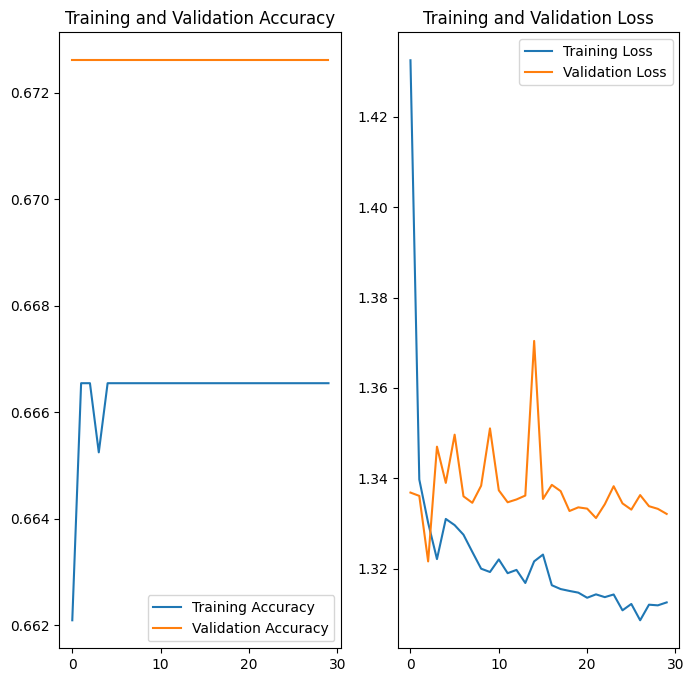

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?¶
Todo: Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

Todo: Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?
Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [36]:
# path_to_training_dataset="r'C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train'"
path_to_training_dataset=r'C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train'

import Augmentor
for i in class_names:
    path = path_to_training_dataset + '\\' + i
#     path = path_to_training_dataset + '/' + i

    p = Augmentor.Pipeline(path, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.flip_left_right(probability=0.4)
    p.flip_top_bottom(probability=0.8)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x226FAB9F290>: 100%|█| 1000/1000 [00:05<00:00, 198.03 Sampl


Initialised with 376 image(s) found.
Output directory set to C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x226FB6D45D0>: 100%|█| 1000/1000 [00:04<00:00, 208.94 Sampl


Initialised with 95 image(s) found.
Output directory set to C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x226FEAA6050>: 100%|█| 1000/1000 [00:05<00:00, 193.60 Sampl


Initialised with 438 image(s) found.
Output directory set to C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x226FA66F950>: 100%|█| 1000/1000 [00:25<00:00, 39.36 Samp


Initialised with 357 image(s) found.
Output directory set to C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x226FAF34190>: 100%|█| 1000/1000 [00:22<00:00, 45.04 Sample


Initialised with 4500 image(s) found.
Output directory set to C:\Users\HP\Desktop\New folder (3)\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output\output.

Executing Pipeline:   0%|                                                               | 0/1000 [00:03<?, ? Samples/s]


AttributeError: 'FileNotFoundError' object has no attribute 'message'

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,actinic keratosis
1,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,actinic keratosis
2,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,actinic keratosis
3,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,actinic keratosis
4,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,actinic keratosis
...,...,...
2234,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,vascular lesion
2235,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,vascular lesion
2236,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,vascular lesion
2237,C:\Users\HP\Desktop\New folder (3)\CNN_assignm...,vascular lesion


In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

5000


# Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\HP\\Desktop\\New folder (3)\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_19ae8b2b-7942-4297-b319-1aaae1c02c05.jpg',
 'C:\\Users\\HP\\Desktop\\New folder (3)\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_25a7b301-eb8c-4738-92d2-0da622dcd472.jpg',
 'C:\\Users\\HP\\Desktop\\New folder (3)\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6c470eab-a294-43c3-aef6-3ae5dd0b1489.jpg',
 'C:\\Users\\HP\\Desktop\\New folder (3)\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8d652d64-9ea9-4768-b142-34af4e751541.jpg',
 'C:\\Users\\HP\\Desktop\\New fo

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

AttributeError: 'DataFrame' object has no attribute 'append'

In [43]:
new_df = pd.concat([original_df,df2],ignore_index=True)

In [44]:
new_df['Label'].value_counts()

Label
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
actinic keratosis             1114
dermatofibroma                1095
pigmented benign keratosis     462
squamous cell carcinoma        181
vascular lesion                139
seborrheic keratosis            77
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### 3rd Model: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

### Todo: Create a training dataset

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11739 files belonging to 10 classes.
Using 9392 files for training.


### Todo: Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11739 files belonging to 10 classes.
Using 2347 files for validation.


### Todo: Create your model (make sure to include normalization)

In [48]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model= Sequential([
       tf.keras.layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),

       # First convolving layer
       layers.Conv2D(32,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),

       # Second convolving layer
       layers.Conv2D(64,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),

       # Third convolving layer
       layers.Conv2D(128,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),

       # Fourth convolving layer
       layers.Conv2D(256,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),

       layers.Dropout(0.5),

       #adding the Flatten layer
       layers.Flatten(),
    
       layers.Dense(256, activation='relu'),
       layers.Dropout(0.25),

       layers.Dense(128, activation='relu'),
       layers.Dropout(0.25),

       # adding Dense layer
       layers.Dense(64, activation='relu'),
       #Dropout layer with 25% Fraction of the input units to drop.
       layers.Dropout(0.25),

       #Dense Layer with softmax activation function.
       #Softmax is an activation function that scales numbers/logits into probabilities.
       layers.Dense(len(class_names),activation='softmax'),
])

model.summary()

C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,360,330 (31.89 MB)

 Trainable params: 8,360,330 (31.89 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [50]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

checkpoint_filepath = 'D:\AI-ML\Main Course Content\Deep Learning\Melanoma Assignment\checkpoint.weights.keras'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Todo: Train your model

In [51]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[checkpoint,earlystop]
)


Epoch 1/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 161s 539ms/step - accuracy: 0.3571 - loss: 1.9864 - val_accuracy: 0.3916 - val_loss: 1.8429
Epoch 2/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 158s 536ms/step - accuracy: 0.3783 - loss: 1.8818 - val_accuracy: 0.3916 - val_loss: 1.8607
Epoch 3/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 161s 546ms/step - accuracy: 0.3783 - loss: 1.8706 - val_accuracy: 0.3916 - val_loss: 1.8376
Epoch 4/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 160s 543ms/step - accuracy: 0.3812 - loss: 1.8604 - val_accuracy: 0.3916 - val_loss: 1.8404
Epoch 5/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 162s 548ms/step - accuracy: 0.3794 - loss: 1.8613 - val_accuracy: 0.3916 - val_loss: 1.8373
Epoch 6/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 160s 541ms/step - accuracy: 0.3781 - loss: 1.8592 - val_accuracy: 0.3916 - val_loss: 1.8361
Epoch 7/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 164s 557ms/step - accuracy: 0.3798 - loss: 1.8576 - val_accuracy: 0.3916 - val_loss: 1.8422
Epoch 8/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 160s 542ms/step - accuracy: 0.3770 -

294/294 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.3811 - loss: 1.8447 - val_accuracy: 0.3916 - val_loss: 1.8349


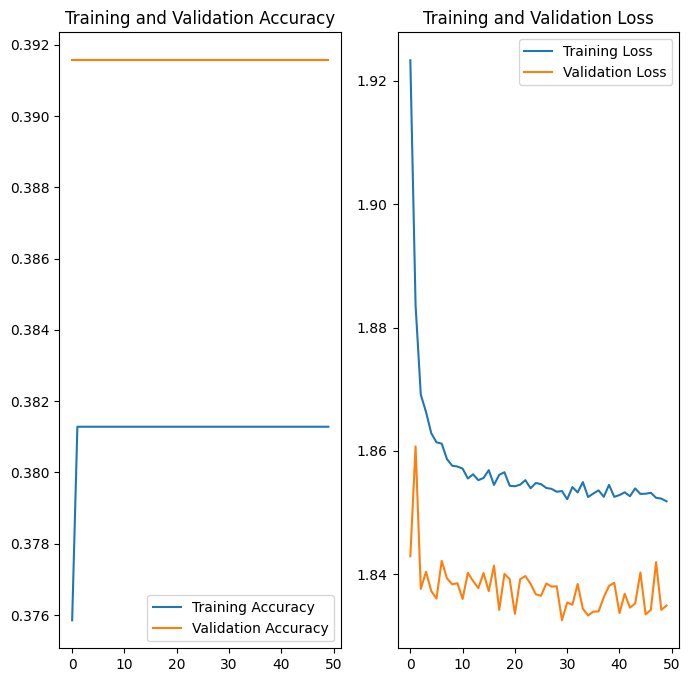

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()